In [ ]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import RMSprop
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#ジャカルタのバスデータ使用
metadata = pd.read_csv('/content/drive/MyDrive/data_science/プログラム/data/transjakarta_gps.csv')
metadata.head()

,bus_code,trip_id,gps_datetime,location,dtd,corridor,longitude,latitude,speed,course,color
0,DMR 5049,5.112,2019-11-26 14:00:29,NaN,0.0,0,106.867523,-6.22423,0.0,208,MERAH KUNING
1,DMR 5049,5.112,2019-11-26 14:00:54,NaN,0.0,0,106.867523,-6.22423,0.0,208,MERAH KUNING
2,DMR 5049,5.112,2019-11-26 14:01:29,NaN,0.0,0,106.867523,-6.22423,0.0,208,MERAH KUNING
3,DMR 5049,5.112,2019-11-26 14:01:59,NaN,0.0,0,106.867523,-6.22423,0.0,208,MERAH KUNING
4,DMR 5049,5.112,2019-11-26 14:02:29,NaN,0.0,0,106.867523,-6.22423,0.0,208,MERAH KUNING


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775458 entries, 0 to 775457
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   bus_code      775458 non-null  object 
 1   trip_id       773791 non-null  object 
 2   gps_datetime  775458 non-null  object 
 3   location      234477 non-null  object 
 4   dtd           775458 non-null  float64
 5   corridor      775458 non-null  object 
 6   longitude     775458 non-null  float64
 7   latitude      775458 non-null  float64
 8   speed         775458 non-null  float64
 9   course        775458 non-null  int64  
 10  color         663910 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 65.1+ MB


In [ ]:
#np.arrayの配列を作成
bus_trip_gps = metadata[["bus_code", "trip_id","gps_datetime", "longitude", "latitude"]]
bus_gps = bus_trip_gps.values

display(bus_gps)

#距離の変位を調査する
bus_gps_plus = np.vstack((np.zeros(2).reshape(1,2), bus_gps[:, 3:5]))
bus_gps_minus = np.vstack((bus_gps[:, 3:5], np.zeros(2).reshape(1,2)))
delta_bus_gps = bus_gps_plus - bus_gps_minus
delta_bus_gps = delta_bus_gps[1:,:]

display(delta_bus_gps)

#直感的に異常値に気付けるように単位をkmにする
delta_bus_gps*=110.94297

#距離のデータを作成
delta_distans = (np.square(delta_bus_gps[:,0:1]) + np.square(delta_bus_gps[:, 1:2]))**0.5

#時間の変化のデータを作成
bus_time_minus = pd.to_datetime(bus_gps[:-1,2:3].reshape(-1))
bus_time_plus = pd.to_datetime(bus_gps[1:,2:3].reshape(-1))
delta_time_gps = bus_time_plus - bus_time_minus
delta_time_gps = delta_time_gps/np.timedelta64(1,'s')
delta_time_gps = np.array(delta_time_gps, dtype='float')
delta_time_gps = np.append(delta_time_gps,0)
delta_time_gps = delta_time_gps.reshape(len(delta_time_gps),1)

display(delta_time_gps)

#変化量、速度を時速になおす
delta_bus_gps /= (delta_time_gps + 1e-8)/(60*60)
delta_distans /= (delta_time_gps + 1e-8)/(60*60)

#bus_gpsに変位と距離を追加する
bus_gps = np.insert(bus_gps,[5] , delta_bus_gps, axis=1)
bus_gps = np.insert(bus_gps,[7] , delta_distans, axis=1)
bus_gps = np.insert(bus_gps,[3] , delta_time_gps, axis=1)

display(bus_gps)


array([['DMR 5049', '5.112', '2019-11-26 14:00:29', 106.867523, -6.22423],
       ['DMR 5049', '5.112', '2019-11-26 14:00:54', 106.867523, -6.22423],
       ['DMR 5049', '5.112', '2019-11-26 14:01:29', 106.867523, -6.22423],
       ...,
       ['TSW 100', '8.D001', '2019-11-26 17:58:53', 106.741697,
        -6.220093],
       ['TSW 100', '8.D001', '2019-11-26 17:59:25', 106.741655,
        -6.220058],
       ['TSW 100', '8.D001', '2019-11-26 17:59:57', 106.741638,
        -6.220033]], dtype=object)

array([[0.0, 0.0],
       [0.0, 0.0],
       [0.0, 0.0],
       ...,
       [4.200000000764703e-05, -3.500000000045134e-05],
       [1.699999999971169e-05, -2.4999999999941735e-05],
       [106.741638, -6.220033]], dtype=object)

array([[25.],
       [35.],
       [30.],
       ...,
       [32.],
       [32.],
       [ 0.]])

array([['DMR 5049', '5.112', '2019-11-26 14:00:29', ..., 0.0, 0.0, 0.0],
       ['DMR 5049', '5.112', '2019-11-26 14:00:54', ..., 0.0, 0.0, 0.0],
       ['DMR 5049', '5.112', '2019-11-26 14:01:29', ..., 0.0, 0.0, 0.0],
       ...,
       ['TSW 100', '8.D001', '2019-11-26 17:58:53', ...,
        0.524205533181629, -0.4368379442441213, 0.6823626825594041],
       ['TSW 100', '8.D001', '2019-11-26 17:59:25', ...,
        0.21217843005509582, -0.3120271030267643, 0.3773335384032543],
       ['TSW 100', '8.D001', '2019-11-26 17:59:57', ...,
        4263204363258549.5, -248424816426483.6, 4270436316387737.0]],
      dtype=object)

In [ ]:
#5回の測定で一回の時系列データとする
#bus_codeとtrip_idで別々の時系列のデータとなるようにする。

gps_input_data=[]
gps_correct_data =[]

len_sequence = 5             # 時系列の長さ

bus_gps[:,0:2] = bus_gps[:,0:2].astype(str)
bus_code_list = np.unique(bus_gps[:,0:1])

for i in range(len(bus_code_list)):
    bus_code = bus_code_list[i]
    bus_code_gps = bus_gps[np.any(bus_gps==bus_code,axis=1)]

    trip_id_list =np.unique(bus_code_gps[:,1:2])

    if i%100 == 0:
        print(i)

    for j in range(len(trip_id_list)):
        trip_id =  trip_id_list[j]
        trip_id_gps = bus_code_gps[np.any(bus_code_gps[:,1:2]==str(trip_id),axis=1)]

        if len(trip_id_gps)>(len_sequence+2):
            for k in range(len(trip_id_gps)-(len_sequence+2)):
                gps_input_data.append(trip_id_gps[k:k+len_sequence,2:])
                gps_correct_data.append(trip_id_gps[k+len_sequence:k+(len_sequence+1),2:].reshape(7))


#インプット用のデータ
#axis0 データ、axis1 同一データ内の時系列位置 axis2 時間、時間変化、緯度,経度,緯度方向変位(km),経度方向変位(km),時速(km/h)
gps_input_data=np.array(gps_input_data)

#正解用のデータ
#axis0 データ、axis1 時間、時間変化、緯度,経度,緯度方向変位(km),経度方向変位(km),時速(km/h)
gps_correct_data =np.array(gps_correct_data)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [ ]:
#異常な値の削除
#正解の時速が150kmを超えているものを異常とみなす

high_distans_index0 = np.where(gps_input_data[:,:,-1]>150)
high_distans_index0 = high_distans_index0[0]

high_distans_index1 = np.where(gps_correct_data[:,-1]>150)
high_distans_index1 = high_distans_index1[0]

error_data_index=np.concatenate([high_distans_index0, high_distans_index1])
error_data_index=np.unique(error_data_index)

gps_input_data2 = np.delete(gps_input_data,error_data_index,axis=0)
gps_correct_data2 = np.delete(gps_correct_data,error_data_index,axis=0)

#データの時系列内での（1個目と5個目）移動距離が0.01km以下のものを異常とする

index_destans0 = np.where(((gps_input_data2[:,:,4].sum(axis=1)**2 + gps_input_data2[:,:,5].sum(axis=1)**2)**0.5) < 0.01)
index_destans0 = np.array(index_destans0)
index_destans0 = index_destans0.reshape(-1)

gps_input_data2 = np.delete(gps_input_data2,index_destans0,axis=0)
gps_correct_data2 = np.delete(gps_correct_data2,index_destans0,axis=0)

#時間の変位が25より小さい,35より大きいデータを異常とみなす

index_time_short0 = np.where(gps_input_data2[:,:,1]<25)
index_time_short0 = index_time_short0[0]
index_time_short1 = np.where(gps_correct_data2[:,1]<25)
index_time_short1 = index_time_short1[0]
index_time_short = np.concatenate([index_time_short0, index_time_short1])

index_time_long0 = np.where(gps_input_data2[:,:,1]>35)
index_time_long0 = index_time_long0[0]
index_time_long1 = np.where(gps_correct_data2[:,1]>35)
index_time_long1 = index_time_long1[0]
index_time_long = np.concatenate([index_time_long0, index_time_long1])

index_time_error = np.concatenate([index_time_long, index_time_short])
index_time_error = np.unique(index_time_error)

gps_input_data2 = np.delete(gps_input_data2,index_time_error,axis=0)
gps_correct_data2 = np.delete(gps_correct_data2,index_time_error,axis=0)

In [ ]:
#データ分割用のインデックスの準備
np.random.seed(0)
all_data_number = len(gps_correct_data)
data_index =np.arange(all_data_number)
np.random.shuffle(data_index)

#時速データの準備
X = gps_input_data[:,:,(1,2,3,6)]
t = gps_correct_data[:,(1,2,3,6)]

#正規化
for i in range(len(t[0,:])):
    Xt_min = np.min((X[:,:,i].min(), t[:,i].min()))
    Xt_max = np.max((X[:,:,i].max(), t[:,i].max()))
    X[:,:,i] = (X[:,:,i]-Xt_min)/Xt_max
    t[:,i] = (t[:,i]-Xt_min)/Xt_max

#データの分割
train_data_number =(all_data_number*3)//5
plot_data_number = (all_data_number*1)//5

X_train = X[data_index[:train_data_number],:,:]
t_train = t[data_index[:train_data_number]]

X_test = X[data_index[train_data_number:(-plot_data_number)],:,:]
t_test = t[data_index[train_data_number:(-plot_data_number)]]

X_plot = X[data_index[(-plot_data_number):],:,:]
t_plot = t[data_index[(-plot_data_number):]]

In [ ]:
# LSTMを定義
input_dim = 4                 # 入力データの次元数
output_dim = 1                # 出力データの次元数
num_hidden_units_1 = 64       # 隠れ層1のユニット数
num_hidden_units_2 = 32       # 隠れ層2のユニット数
batch_size = 1000             # ミニバッチサイズ
num_of_training_epochs = 3  # 学習エポック数

model = Sequential()
model.add(LSTM(num_hidden_units_1,
              input_shape=(len_sequence,input_dim),
              return_sequences = True,
              recurrent_dropout = 0.5))
model.add(LSTM(num_hidden_units_2,
              recurrent_dropout = 0.3))
model.add(Dense(output_dim))
model.compile(loss="mae",
              optimizer=RMSprop())
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 64)             17664     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/3
448/448 [==============================] - 58s 117ms/step - loss: 0.0258 - val_loss: 0.0250
Epoch 2/3
448/448 [==============================] - 58s 130ms/step - loss: 0.0251 - val_loss: 0.0251


<ipython-input-32-73b669910ee2>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(num_of_training_epochs),history.history["loss"], 'bo',color='red', label='Training loss',markersize=3)
<ipython-input-32-73b669910ee2>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(num_of_training_epochs),history.history["val_loss"], 'b',color='blue', label='Validation loss')


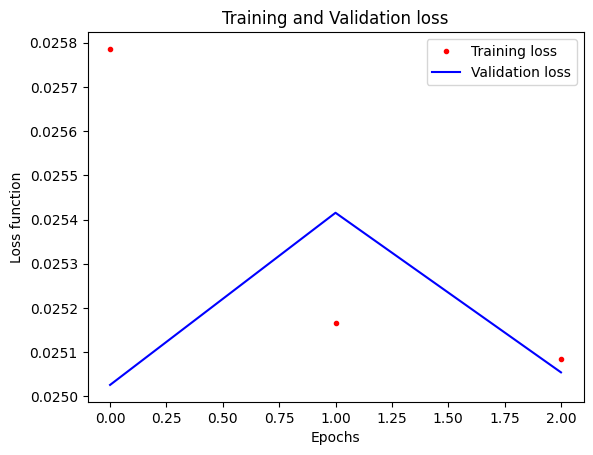

In [ ]:
t_train = t_train.astype(np.float32)
t_test = t_test.astype(np.float32)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
history = model.fit(X_train, t_train,
                  epochs = num_of_training_epochs,
                  batch_size = batch_size,
                  validation_data = (X_test,t_test))
#学習結果の可視化
plt.plot(range(num_of_training_epochs),history.history["loss"], 'bo',color='red', label='Training loss',markersize=3)
plt.plot(range(num_of_training_epochs),history.history["val_loss"], 'b',color='blue', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.show()

In [ ]:
#時系列内で最後の一つ前から最後のデータの加速度が一定であると想定したときの平均絶対誤差(mae)を計算する
#ただしデータ取得の間隔が一定であると仮定する

batch_maes = []
for i in range(len(X_test)//batch_size):
    preds = X_test[i*batch_size:(i+1)*batch_size,-1,-1]*2 -X_test[i*batch_size:(i+1)*batch_size,-2,-1]
    terget = t_test[i*batch_size:(i+1)*batch_size,-1]
    mae = np.mean(np.abs(preds-terget))
    batch_maes.append(mae)

standard_mae = np.mean(batch_maes)
print("平均絶対誤差（正規化）：" + str(standard_mae))
#平均絶対誤差（正規化）：0.0009700724
print("平均絶対誤差 （km/h） ：" + str(standard_mae * Xt_max))
#平均絶対誤差 （km/h） ：11.100591540619897

平均絶対誤差（正規化）：0.0009700724
平均絶対誤差 （km/h） ：11.100591540619897


In [ ]:
X_plot = X_plot.astype(np.float32)
plot_predict = model.predict(X_plot, batch_size=1)

#予測した値とy_plotとの絶対誤差を計算する
plot_predict_mae=np.abs(plot_predict[:,0]-t_plot[:,-1])

#gps_correct_dataからプロット用のデータを作成
gps_plot_data = gps_correct_data[data_index[(-plot_data_number):],:]
plot_data = np.concatenate([gps_plot_data,plot_predict_mae.reshape(len(plot_predict_mae),1)], axis=1)
plot_data=plot_data[:,(0,2,3,7)]

#plot用の絶対誤差と常識的な基準として作成した平均絶対誤差を比較する
#plot用の絶対誤差 < 常識的な平均絶対誤差 となるデータを正常とする
#plot用の絶対誤差 > 常識的な平均絶対誤差 となるデータを異常とする
clustering_normaly_gps = X_plot[np.where(plot_data[:,-1]<standard_mae)[0],:,-1]
clustering_anormaly_gps = X_plot[np.where(plot_data[:,-1]>standard_mae)[0],:,-1]

149242/149242 [==============================] - 688s 5ms/step


In [ ]:
#クラスタリングに用いるデータ数
clustering_data_number = 10000

#データ分割用のインデックスの準備
np.random.seed(0)
normaly_data_number = len(clustering_normaly_gps)
normaly_data_index = np.arange(normaly_data_number)
np.random.shuffle(normaly_data_index)
anormaly_data_number = len(clustering_anormaly_gps)
anormaly_data_index = np.arange(anormaly_data_number)
np.random.shuffle(anormaly_data_index)

#時速データの準備
normaly_ts_dataset = clustering_normaly_gps[normaly_data_index[:clustering_data_number],:]
anormaly_ts_dataset = clustering_anormaly_gps[anormaly_data_index[:clustering_data_number],:]

#データの保存
silhouette_normaly_data = []
km_normaly_labels = []
km_normaly_center = []
silhouette_anormaly_data = []
km_anormaly_labels = []
km_anormaly_center = []

#クラスタリングの実行
metric = 'euclidean'
n_clusters = [n for n in range(2, 10)]

print("正常値のクラスタリング")
for n in n_clusters:
    km= TimeSeriesKMeans(n_clusters=n, metric=metric, verbose=False, random_state=1).fit(normaly_ts_dataset)
    print('クラスター数 ='+ str(n) + 'シルエット係数 ='+ str(silhouette_score(normaly_ts_dataset, km.labels_, metric=metric)))
    silhouette_normaly_data.append(np.array([n, silhouette_score(normaly_ts_dataset, km.labels_, metric=metric)]))
    km_normaly_labels.append([n, km.labels_])
    km_normaly_center.append([n, km.cluster_centers_])

print("異常値のクラスタリング")
for n in n_clusters:
    km= TimeSeriesKMeans(n_clusters=n, metric=metric, verbose=False, random_state=1).fit(anormaly_ts_dataset)
    print('クラスター数 ='+ str(n) + 'シルエット係数 ='+ str(silhouette_score(anormaly_ts_dataset, km.labels_, metric=metric)))
    silhouette_anormaly_data.append(np.array([n, silhouette_score(anormaly_ts_dataset, km.labels_, metric=metric)]))
    km_anormaly_labels.append([n, km.labels_])
    km_anormaly_center.append([n, km.cluster_centers_])

正常値のクラスタリング
クラスター数 =2シルエット係数 =0.35377163
クラスター数 =3シルエット係数 =0.27983645
クラスター数 =4シルエット係数 =0.29089877
クラスター数 =5シルエット係数 =0.29493052
クラスター数 =6シルエット係数 =0.27046618
クラスター数 =7シルエット係数 =0.25935888
クラスター数 =8シルエット係数 =0.22164328
クラスター数 =9シルエット係数 =0.22783215
異常値のクラスタリング
クラスター数 =2シルエット係数 =0.58315486
クラスター数 =3シルエット係数 =0.5834817
クラスター数 =4シルエット係数 =0.5411415
クラスター数 =5シルエット係数 =0.5622409
クラスター数 =6シルエット係数 =0.5637322
クラスター数 =7シルエット係数 =0.56493163
クラスター数 =8シルエット係数 =0.5588136
クラスター数 =9シルエット係数 =0.52286994


In [ ]:
#gps_correct_dataからプロット用のデータを作成
gps_plot_data = gps_correct_data[data_index[(-plot_data_number):],:]
plot_data=np.concatenate([gps_plot_data,plot_predict_mae.reshape(len(plot_predict_mae),1)], axis=1)
plot_data=plot_data[:,(0,2,3,7)]

plot_normaly_gps = plot_data[np.where(plot_data[:,-1]<standard_mae)[0],:]
plot_anormaly_gps = plot_data[np.where(plot_data[:,-1]>standard_mae)[0],:]

#normal用データ作成
#-1=<シルエット係数=<1, 1に近いほどクラスタリング精度が高い
n_cluster = 2
lavel = 2

km_labels = km_normaly_labels[n_cluster][1]
normaly_plot_data = plot_normaly_gps[normaly_data_index[:clustering_data_number],:]
normaly_plot_data_label = normaly_plot_data[np.where(km_labels.reshape(clustering_data_number,1)==lavel)[0],:]
df_normaly_plot_lavel = pd.DataFrame(normaly_plot_data_label, columns=['gps_datetime', 'longitude', 'latitude', 'error'])
df_normaly_plot_lavel.head()
#df_normaly_plot_lavel.to_csv('normaly_plot_lavel='+str(lavel)+'(渋滞の入り口).csv')

,gps_datetime,longitude,latitude,error
0,2019-11-26 17:04:07,106.830515,-6.209763,0.000027
1,2019-11-26 16:58:08,106.833968,-6.204375,0.000865
2,2019-11-26 16:39:41,106.775827,-6.163663,0.000156
3,2019-11-26 17:28:50,106.798083,-6.136793,0.000718
4,2019-11-26 17:57:54,106.840468,-6.303097,0.000606


・薄い水色のデータ=（正常）渋滞データ
/黄色のデータ=（正常）渋滞入口データ
/緑色のデータ=（正常）渋滞出口データ [kepler.glより](https://kepler.gl/)

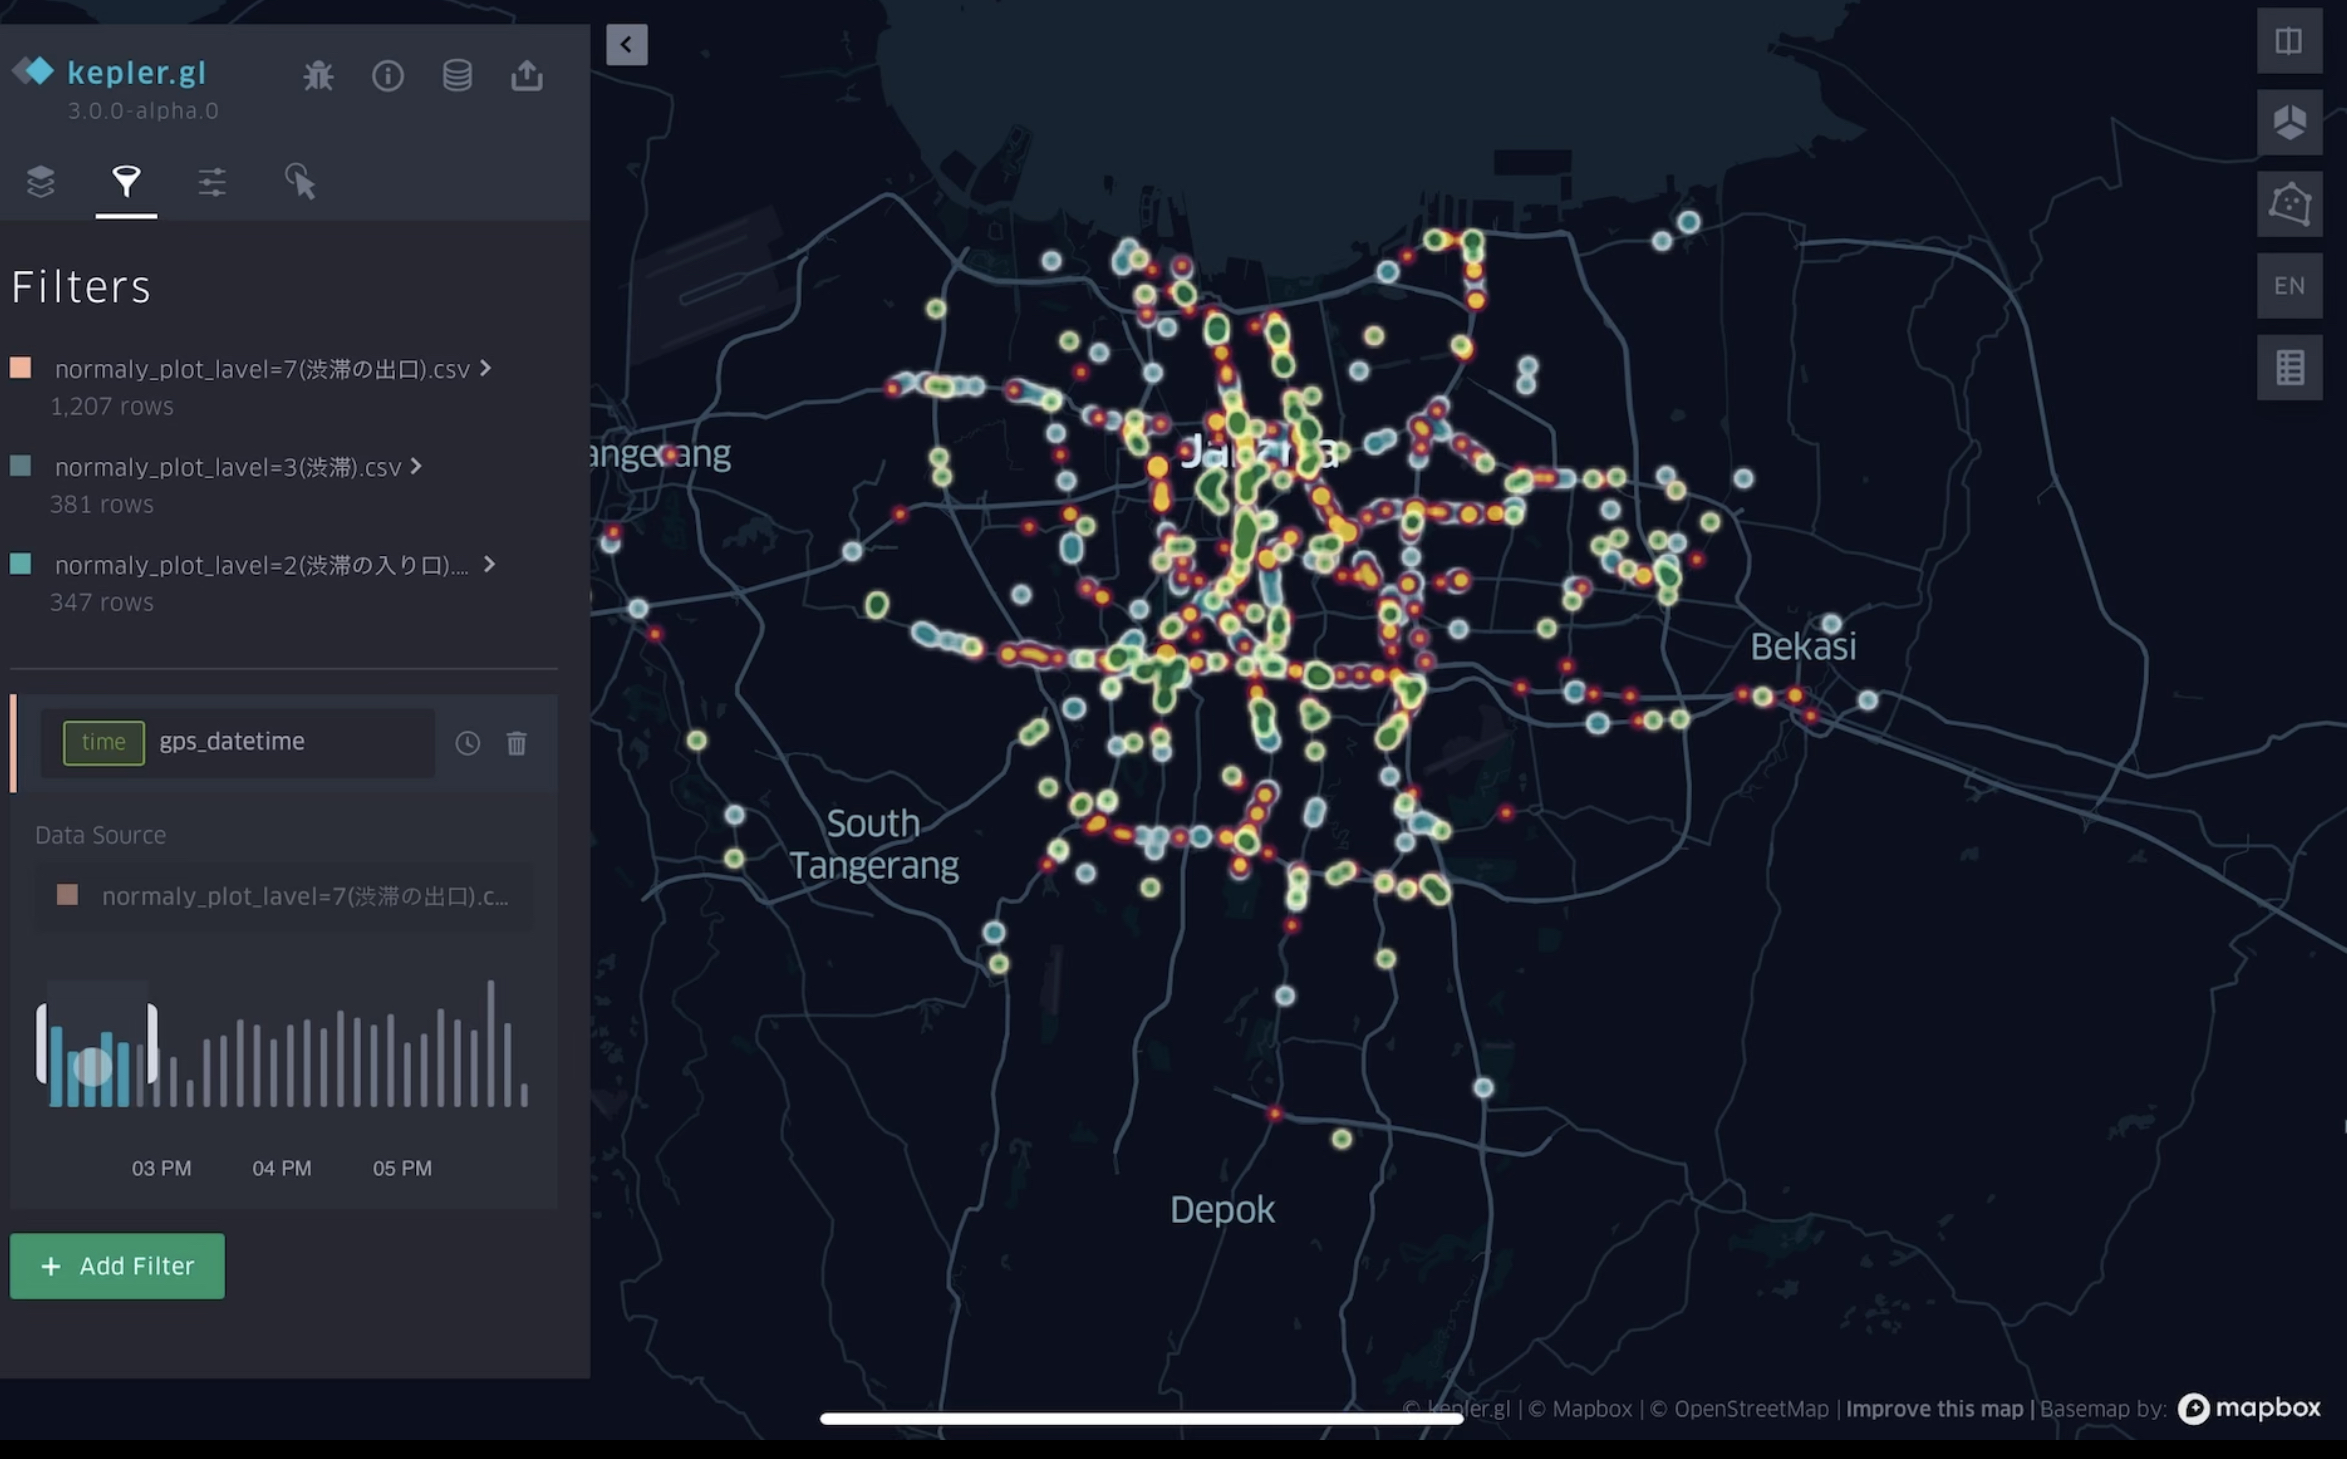